# Notebook Dedicated to Represent the High Statistical MC data for $\alpha$-n Data and the fit results to Dt and Dr

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

from scipy.special import factorial
from lmfit import Model
from scipy.optimize import curve_fit

import pandas as pd

import glob

# Load Data

Lets read the data as follows:
1) Create a list of the main folders output_0, output_1, ...
2) Create a list with the file names of the observables to be readen
3) Take the ith diretory of the list of main folders, and join it to the observable name list to be readen and save the observables values for each iteration over output_i folders

In [2]:
#Main Data Directory
main_dir = 'E:/Data/antinu/mc/alpha_n/out_results/'
folder_name_pattern = 'output_*/'

main_dir_list = glob.glob(main_dir + folder_name_pattern)
main_dir_list

#Observable file names to be readen
obs_real_list = ['dt', 'dr', 'energy_prompt', 'energy_delay']

#Dictionary with empty np.arrays of the observables to be readen
observable_dict = {obs_i : np.array([]) for obs_i in obs_real_list}

#Iteration over main directory list
for main_dir_list_i in main_dir_list:
    print(f'reading folder {main_dir_list_i}')
    #Create the directories for the observables (defined along the next iteration) to be readen using the main_dir_list_i and save its value
    for obs_i in obs_real_list:
        print(f'saving information of observable {obs_i}')
        dir_obs_i = main_dir_list_i + obs_i + '.npy'  #Create the full directory of the observable 
        array_obs_i = np.load(dir_obs_i)              #Load the numpy array of the corresponding observable obs_i
        observable_dict[str(obs_i)] = np.append(observable_dict[str(obs_i)], array_obs_i)  #Save the observable in the dictionary


#Define energy cut on prompt and delay to plot. In the MC data is seen how there are energy values higher than 8 MeV
#Extract energy arrays to perform cuts
energy_prompt = observable_dict['energy_prompt']
energy_delay = observable_dict['energy_delay'] #Limit energy delay, but this is strange to be larger ...
dt = observable_dict['dt']
dr = observable_dict['dr']

energy_prompt_sup_cut = 8.0
energy_delay_sup_cut = 4.0

dt_sup_lim = 2000
dt_inf_lim = 0

dr_sup_lim = 1000.0

cut_condition = (energy_prompt <= energy_prompt_sup_cut) & (energy_delay <= energy_delay_sup_cut) & (dt > dt_inf_lim) & (dt <= dt_sup_lim) & (dr <= dr_sup_lim)

energy_prompt = energy_prompt[cut_condition]
energy_delay = energy_delay[cut_condition]
dt = dt[cut_condition]
dr = dr[cut_condition]

reading folder E:/Data/antinu/mc/alpha_n/out_results\output_0\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/alpha_n/out_results\output_1\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/alpha_n/out_results\output_10\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/alpha_n/out_results\output_11\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/alpha_n/out_results\output_12\
saving information of 

In [3]:
energy_prompt.shape

(979859,)

In [4]:
energy_delay.shape

(979859,)

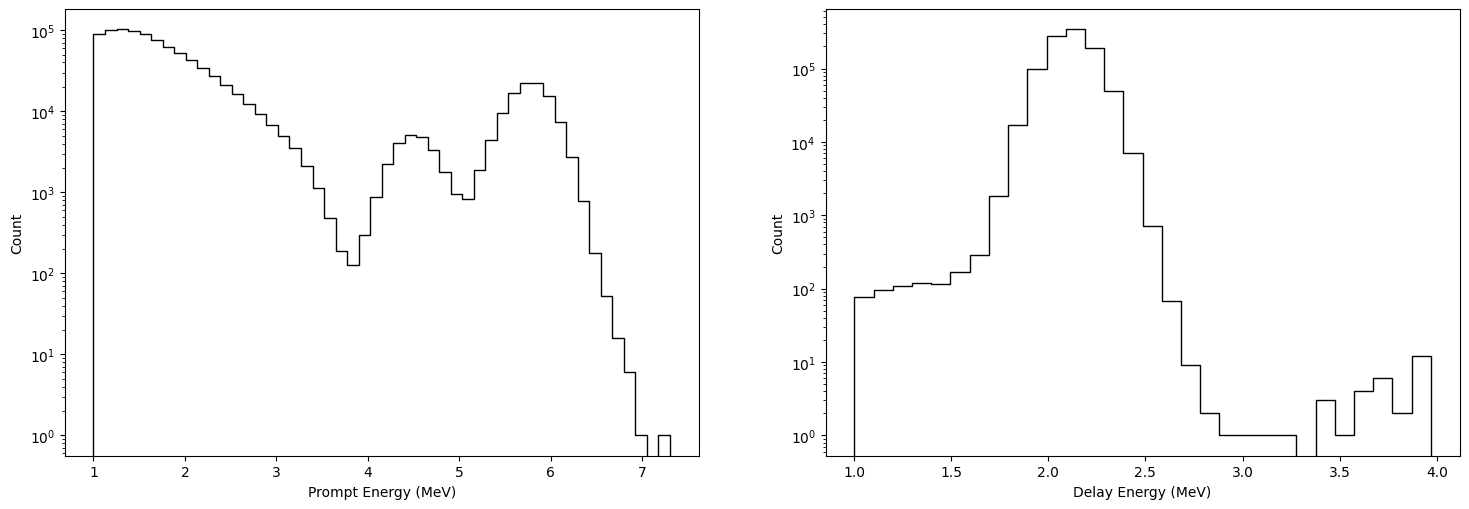

In [5]:
bins_prompt = 50
bins_delay = 30

fig, axes = plt.subplots(1, 2,  figsize=(18, 5.8))

sn.histplot(energy_prompt, ax = axes[0],  bins = bins_prompt, color = 'black', element = 'step', alpha = 0)
sn.histplot(energy_delay, ax = axes[1], bins = bins_delay, color = 'black', element = 'step', alpha = 0)

axes[0].set_xlabel('Prompt Energy (MeV)')
axes[0].set_yscale('log')

axes[1].set_xlabel('Delay Energy (MeV)')
axes[1].set_yscale('log')

#plt.suptitle(main_title + primary_cuts_title + '\n' + secondary_titles, fontsize = 12)
#plt.savefig(save_dir + 'prompt and delay energy/energy_' + main_title_save+'.png', format = 'png', bbox_inches = 'tight')

plt.show()

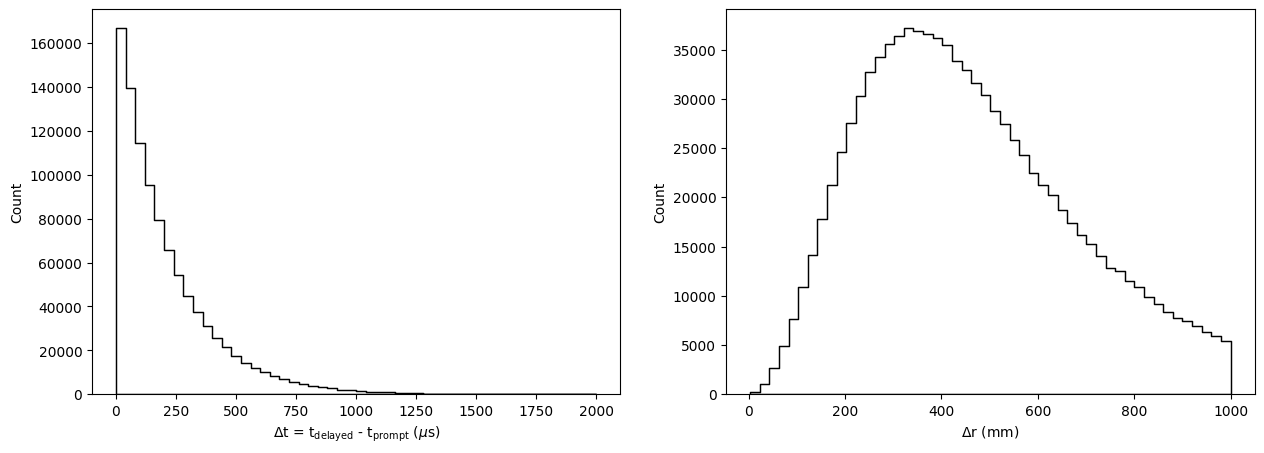

In [6]:
save_fig = False

bins_t = 50
bins_r = 50

linewidth = 1.05

fig, axes = plt.subplots(1, 2,  figsize=(15, 5))

sn.histplot(dt, bins = bins_t, ax = axes[0], color = 'black', alpha = 0.0, element = 'step', linewidth = linewidth)
sn.histplot(dr, bins = bins_r, ax = axes[1], color = 'black', alpha = 0.0, element = 'step' , linewidth = linewidth)

axes[0].set_xlabel(r'$\Delta$t = t$_{\text{delayed}}$ - t$_{\text{prompt}}$ ($\mu$s)')

axes[1].set_xlabel(r'$\Delta$r (mm)')

#plt.suptitle(r'Reactor $\bar{\nu}$ - E $\geq$ ' + str(en_cut) + ' (MeV) & R $\leq$ '+ str(r_cut) + ' (mm)')

#if save_fig:
#    plt.savefig('figs/dt_dr_E_{i}MeV_R_{j}mm.png'.format(i = en_cut, j = r_cut), format = 'png', bbox_inches = 'tight')
    
plt.show()

# Perform Fit to Dt and Dr

## Define the Functions to Fit

### Exponential Decay for Dt

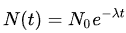

In [7]:
def fit_exp(x, n0, lambda_):
    return n0 * np.exp(lambda_ * x)

### Gaussian for Dr 

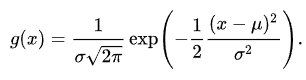

In fact Dr follows more a Landau, but with suitable cuts it looks like a Gaussian

In [8]:
def fit_gauss(x, sigma, mu):
    # mu -> Mean value
    #sigma -> Standard deviation
    a = 1/(sigma * np.sqrt(2*np.pi))
    return a * np.exp((-1/2) * ((x - mu)**2) / (sigma**2))

## Fit Procedure

### Extract the Data Points

In [20]:
dr_sup_lim = 1000
dr_inf_lim = 70

dr_cut = np.array(dr[(dr < dr_sup_lim) & (dr >= dr_inf_lim)])

bins_t = 50
bins_r = 50

counts_t, bins_edge_t = np.histogram(dt, bins = bins_t)
counts_r, bins_edge_r = np.histogram(dr_cut, bins = bins_r, density = True)

#Counts are y-axis values and bins_center are x_axis values
bins_center_t = (bins_edge_t[:-1] + bins_edge_t[1:]) / 2
bins_center_t = np.round(bins_center_t, decimals = 2)

bins_center_r = (bins_edge_r[:-1] + bins_edge_r[1:]) / 2
bins_center_r = np.round(bins_center_r, decimals = 2)

### Dt Fit

In [12]:
y_t = counts_t
x_t = bins_center_t

fit_model_dt = Model(fit_exp)
result_dt = fit_model_dt.fit(y_t, x = x_t, n0 = 1, lambda_ = 1/150)

n0 = result_dt.best_values['n0']
lambda_ = result_dt.best_values['lambda_']

lambda_err = result_dt.params['lambda_'].stderr
n0_err = result_dt.params['n0'].stderr

tau = -1/lambda_
tau_err = lambda_err/(lambda_**2)  #error propagation
tau 

print(result_dt.fit_report())

[[Model]]
    Model(fit_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 98
    # data points      = 50
    # variables        = 2
    chi-square         = 8.3168e+08
    reduced chi-square = 17326686.5
    Akaike info crit   = 835.346822
    Bayesian info crit = 839.170868
    R-squared          = 0.99998204
[[Variables]]
    n0:       4733343.13 +/- 3678.94330 (0.08%) (init = 1)
    lambda_: -0.00468279 +/- 5.1079e-06 (0.11%) (init = 0.006666667)
[[Correlations]] (unreported correlations are < 0.100)
    C(n0, lambda_) = -0.7165


### Dr - Gaussian Fit

In [21]:
y_r = counts_r
x_r = bins_center_r

fit_model_dr_gauss = Model(fit_gauss)
result_dr_gauss = fit_model_dr_gauss.fit(y_r, x = x_r, sigma = np.std(dr_cut), mu = np.mean(dr_cut))

sigma_op_gauss = result_dr_gauss.best_values['sigma']
mu_op_gauss = result_dr_gauss.best_values['mu']

mu_err_gauss = result_dr_gauss.params['mu'].stderr

print(result_dr_gauss.fit_report())

[[Model]]
    Model(fit_gauss)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 50
    # variables        = 2
    chi-square         = 1.4836e-06
    reduced chi-square = 3.0908e-08
    Akaike info crit   = -862.653913
    Bayesian info crit = -858.829867
    R-squared          = 0.90237194
[[Variables]]
    sigma:  222.968763 +/- 5.91677484 (2.65%) (init = 211.2594)
    mu:     403.844472 +/- 7.16997495 (1.78%) (init = 457.0956)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, mu) = -0.1214


### Fit Plots

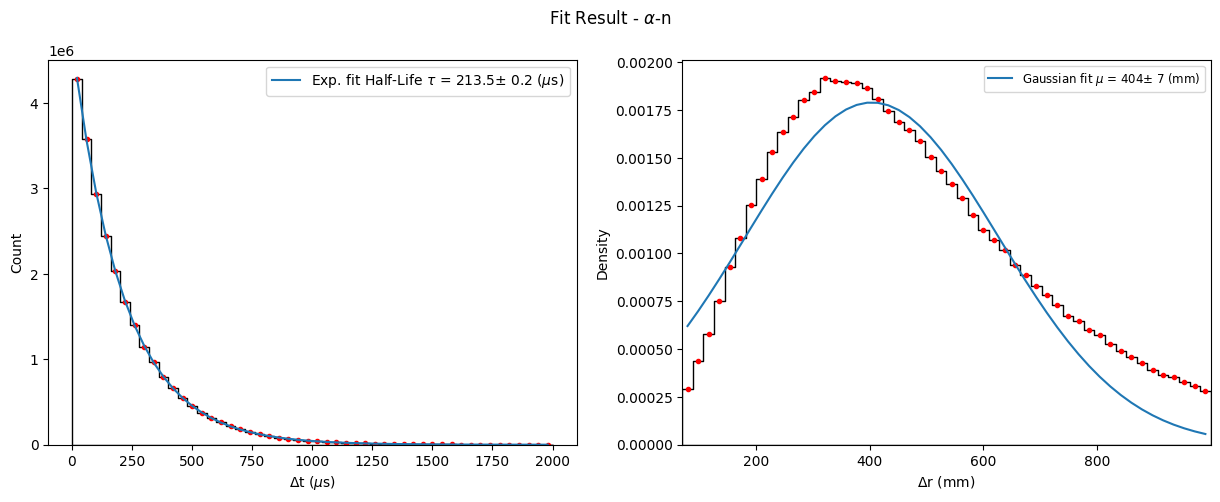

In [22]:
save = False

fig, axes = plt.subplots(1, 2,  figsize=(15, 5))

sn.histplot(dt, bins = bins_t, ax = axes[0], color = 'black', alpha = 0.0, element = 'step')
axes[0].scatter(x = bins_center_t, y = counts_t, color = 'r', marker='.')
axes[0].plot(x_t, result_dt.best_fit, label = rf'Exp. fit Half-Life $\tau$ = {tau:.1f}$\pm$ {tau_err:.1f} ($\mu$s)')

sn.histplot(dr_cut, bins = bins_r, ax = axes[1], color = 'black', alpha = 0.0, element = 'step', stat = 'density')
axes[1].scatter(x = bins_center_r, y = counts_r, color = 'r', marker='.')
axes[1].plot(x_r, result_dr_gauss.best_fit, label = rf'Gaussian fit $\mu$ = {mu_op_gauss:.0f}$\pm$ {mu_err_gauss:.0f} (mm)')


axes[0].legend(loc= 'upper right', fontsize = 10)
axes[0].set_xlabel(r'$\Delta$t ($\mu$s)')

axes[1].legend(loc= 'upper right', fontsize = 8.5)
axes[1].set_xlabel(r'$\Delta$r (mm)')
axes[1].set_xlim(min(dr_cut), max(dr_cut))

plt.suptitle(r'Fit Result - $\alpha$-n')

if save:
    plt.savefig('figs/Fit_Dt_Dr.png', format='png', bbox_inches = 'tight')

plt.show()